# Final Project for Atm-ocean interations
Examine the predictive role of teleconnections on Western Antarctic sea ice extremes

# Setup and Load Data

In [2]:
import os
import sys
from glob import glob

import cartopy.crs as ccrs
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr

from scipy.stats import pearsonr, linregress

# Local Utils
sys.path.insert(0, "/glade/work/zespinosa/Projects/utils")
from utils import (
    from_pickle, 
    to_pickle, 
    xarray_time_to_monthly,
    xarray_monthly_to_time,
    get_season,
)

In [3]:
# UTILS
def read_file(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(fill, np.nan)

    return ds

# Load IPO, SAM, NINO 3.4
root = "/glade/work/zespinosa/data/index/"
ipo = read_file(np.zeros((2023 - 1854, 12)), os.path.join(root, "IPO-TPI_NOAA-ERSSTV5_1854-2022_monthly.txt"), len_header=2)
nino34 = read_file(np.zeros((2023 - 1870, 12)), os.path.join(root, "Nino34_ESRL-NOAA_HADISST_1870-2022_monthly.txt"), len_header=2)
sam_marshall = read_file(np.zeros((2023 - 1957, 12)), os.path.join(root, "SAM_Marshall-1957-2022_monthly.txt"), len_header=4)
sam_fogt = read_file(np.zeros((2006 - 1865, 4)), os.path.join(root, "SAM_Fogt_1865-2005_seasonal.txt"), len_header=3)

In [4]:
# Load DJF Sea Ice Reconstructions
root = "/glade/work/zespinosa/data/recon/Fogt_et_al_2022_best-fit_Antarctic-sie-reconstructionn_1905-2020_seasonal"
ross_amundsen = xr.open_dataset(os.path.join(root, "Ross_Amundsen_best_fit_recons_DJF.nc"))
amundsen_belling = xr.open_dataset(os.path.join(root, "Amundsen_Bellingshausen_best_fit_recons_DJF.nc"))
total = xr.open_dataset(os.path.join(root, "Total_best_fit_recons_DJF.nc"))
weddell = xr.open_dataset(os.path.join(root, "Weddell_best_fit_recons_DJF.nc"))

In [5]:
# Load Observations
# nsidc.close()
nsidc = xr.open_dataset("/glade/work/zespinosa/Projects/ATM_OCEAN_FINAL/sia_sie_NSIDC_recon_197901-202210.nc")
nsidc["region"] = ["Amundsen-Bellingshausen", "Ross-Amundsen", "East", "Weddell", "Total"]

# Variance

Text(0.0, 1.0, 'SIE')

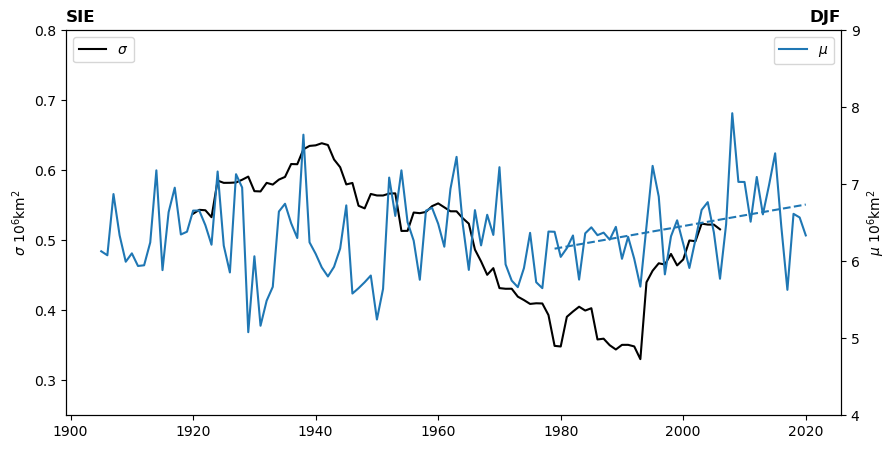

In [53]:
total_var = total.best_fit.rolling(dim={"time": 30}, center=True, min_periods=30).std()
fig, ax1 = plt.subplots(1, figsize=(10, 5))
ax1.plot(total_var.time, total_var, c="black", label=r"$\sigma$")
ax1.set_ylim(.25,.80)
ax1.legend(loc="upper left")
ax1.set_ylabel(r"$\sigma$ $10^6$km$^2$")

ax2 = ax1.twinx()


ax2.plot(total.time, total.best_fit, c="tab:blue", label=r"$\mu$")
ax2.set_ylim(4,9)
ax2.legend(loc="upper right")
ax2.set_ylabel(r"$\mu$ $10^6$km$^2$")

modern_sie = total.best_fit.sel(time=np.arange(1979, 2021))
reg = linregress(modern_sie.time, modern_sie)
ax2.plot(modern_sie.time, reg.slope*modern_sie.time + reg.intercept, color="tab:blue", linestyle="dashed")

ax2.set_title("DJF", fontweight="bold", loc="right")
ax2.set_title("SIE", fontweight="bold", loc="left")

# Extreme Values

In [10]:
def get_season_anchored(df, season="DJF"):
    """
    Get seasonal averages where annual year is anchored on December. Solves the problem in xarray where DJF gets discontinuous december. 
    (e.g. season=DJF and D is in 2021, F is in 2022, df would be indexed on 2022)
    """
    # Define season to index order
    seasons = {"MAM":(1,3), "JJA":(2,6), "SON": (3,9), "DJF":(4,12)}
    sidx, mon = seasons[season]
    
    # Anchor beginning of year in December
    df_season = df.resample(time='QS-DEC') 
    
    # Generate groups based on season
    df_season = df_season.mean(["time"])
    times = [t.values for t in df_season.time if t.dt.month == mon]
    df_season = df_season.sel(time=times)
    
    # Reindex time based on year of last month 
    # (i.e. so season=DJF and D is in 2021, F is in 2022, df would be indexed on 2022)
    df_season["time"] = df_season.time.dt.year + 1
    df_season = df_season.rename({"time": "year"})
    
    return df_season
    
# Get 2022 index and sia data
season_idx="DJF"
season_ice="DJF"
ipo_2022 = get_season_anchored(xarray_monthly_to_time(ipo), season_idx).sel(year=2022)
nino34_2022 = get_season_anchored(xarray_monthly_to_time(nino34), season_idx).sel(year=2022)
sam_2022 = get_season_anchored(xarray_monthly_to_time(sam_marshall), season_idx).sel(year=2022)
nsidc_2022 = get_season_anchored(nsidc.sie.T, season_ice).sel(year=2022)

ipo_2017 = get_season_anchored(xarray_monthly_to_time(ipo), season_idx).sel(year=2017)
nino34_2017 = get_season_anchored(xarray_monthly_to_time(nino34), season_idx).sel(year=2017)
sam_2017 = get_season_anchored(xarray_monthly_to_time(sam_marshall), season_idx).sel(year=2017)
nsidc_2017 = get_season_anchored(nsidc.sie.T, season_ice).sel(year=2017)

Simple Regression Plots

TODO:
4. Calculate running variance for 30 year periods
5. Get correct units

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

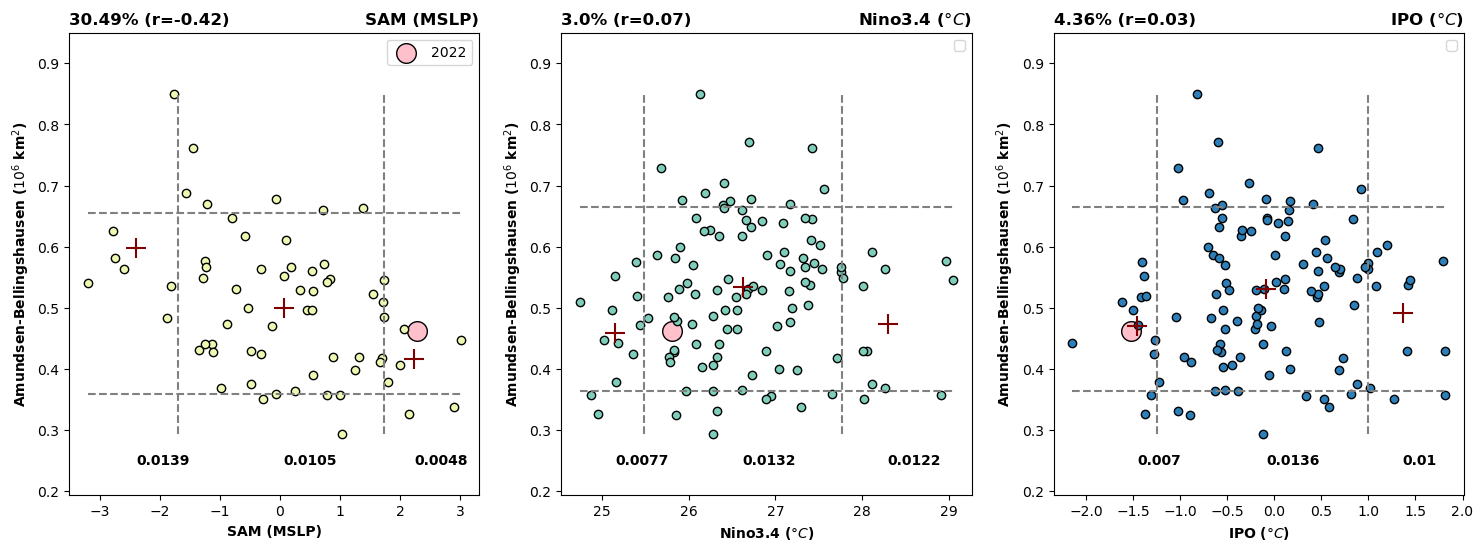

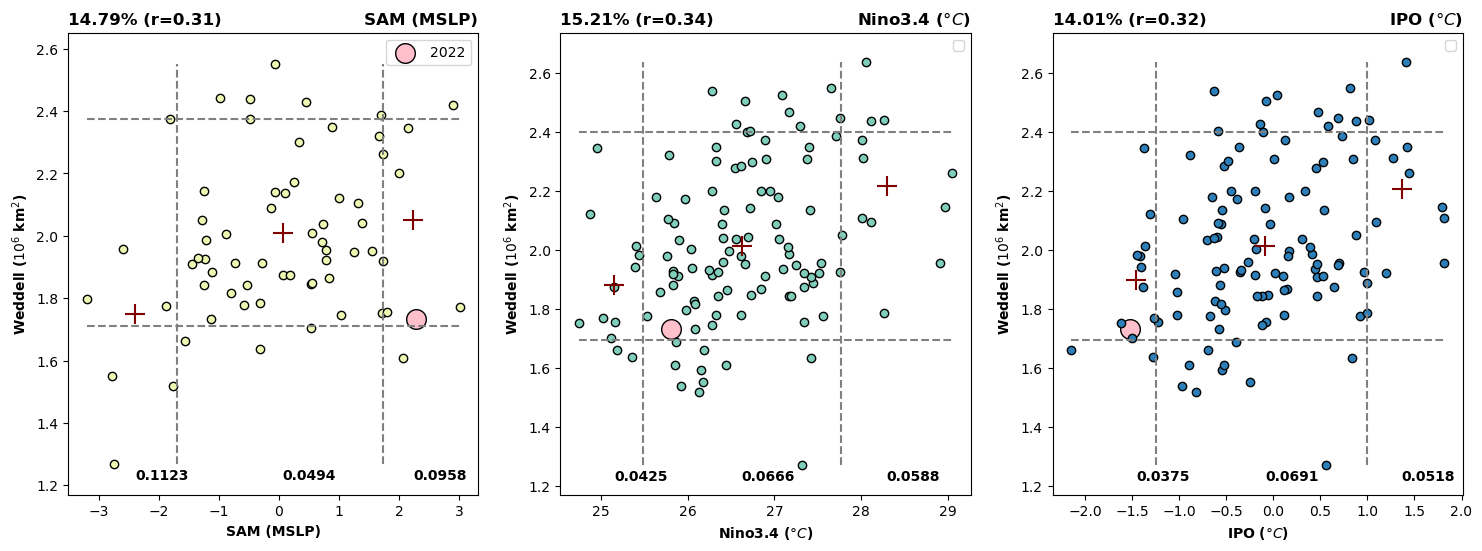

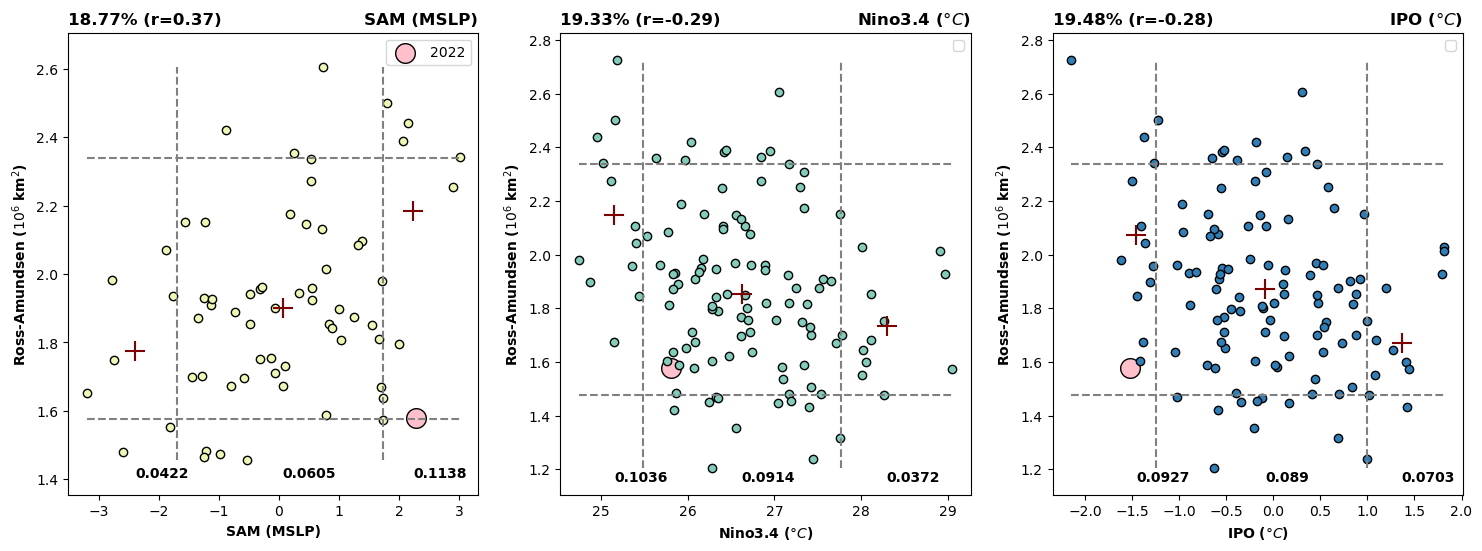

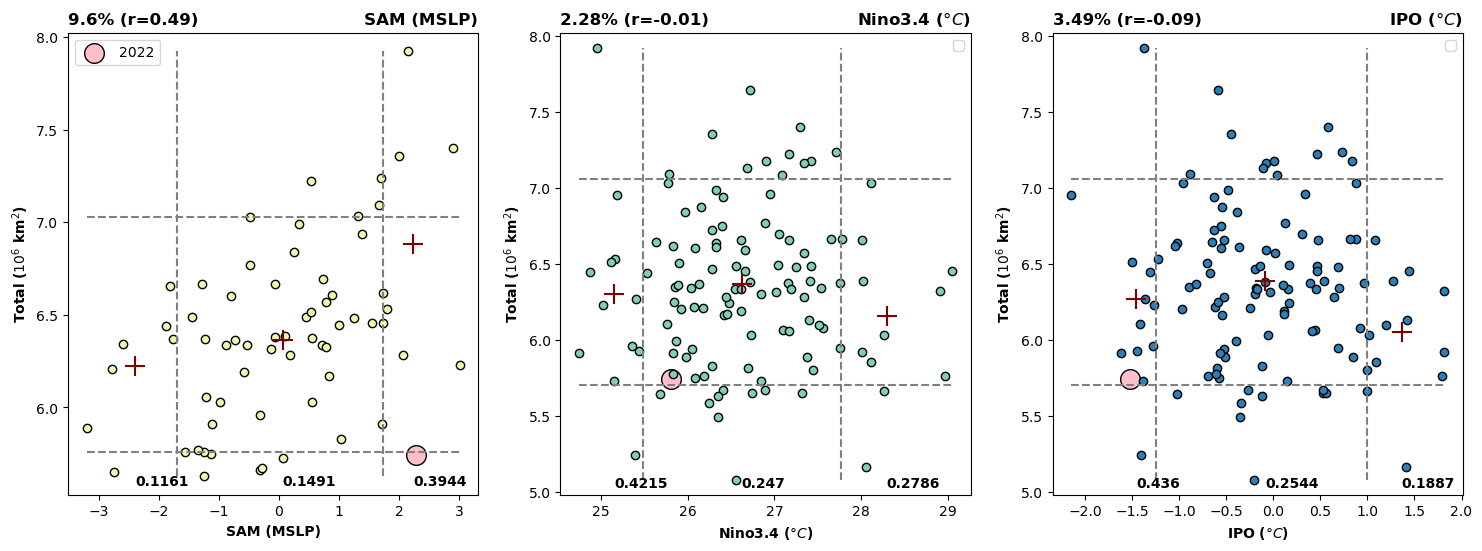

In [28]:
colors = ['#edf8b1','#7fcdbb','#2c7fb8']
def plot_indx_region(sie, idxs, sie_region, season="DJF", season_ice="DJF"):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    for i, (idx_title, idx_df) in enumerate(idxs.items()):
        idx_df, idx_2022, idx_2017 = idx_df
        ax = axs[i]
        idx_son = get_season_anchored(xarray_monthly_to_time(idx_df), season)
        
        time = list(set(idx_son.year.values) & set(sie.time.values)) # union of times
        
        cur_sie = sie.best_fit.sel(time=time).values
        cur_idx = idx_son.sel(year=time).values
        
        # Get value of most extremes
        sie_10, sie_90 = np.quantile(cur_sie, q=[.1, .9])
        idx_10, idx_90 = np.quantile(cur_idx, q=[.1, .9])
        
        ax.vlines([idx_10, idx_90], ymin=np.min(cur_sie), ymax=np.max(cur_sie), color="gray", linestyle="dashed")
        ax.hlines([sie_10, sie_90], xmin=np.min(cur_idx), xmax=np.max(cur_idx), color="gray", linestyle="dashed")
        ax.set_ylim(np.nanmin(cur_sie)-.1, np.nanmax(cur_sie)+.1)
        
        # Get regression coeffs
        r, p = pearsonr(cur_sie, cur_idx)
        r = np.around(r, 2)
        
        reg = linregress(cur_idx, cur_sie)
        # ax.plot(cur_idx, reg.slope*cur_idx + reg.intercept, color="black", linestyle="dashed")
        
        # NSIDC SIE for 2022 (recent minimum)
        label_2022 = ""
        if i == 0: label_2022 = "2022"
        ax.scatter(idx_2022, nsidc_2022.sel(region=sie_region), s=200, color="pink", edgecolor="black", label=label_2022)
            
        # Reconstruction
        ax.scatter(
            x=cur_idx,
            y=cur_sie,
            color=colors[i],
            edgecolor='black'
        )
        
        # Quantile Averages
        idx_10_x = np.nanmean(cur_idx[np.argwhere(cur_idx <= idx_10)])
        idx_10_y = np.nanmean(cur_sie[np.argwhere(cur_idx <= idx_10)])
        
        idx_90_x = np.nanmean(cur_idx[np.argwhere(cur_idx >= idx_90)])
        idx_90_y = np.nanmean(cur_sie[np.argwhere(cur_idx >= idx_90)])
        
        idx_mid_x = np.nanmean(cur_idx[np.argwhere((idx_10 < cur_idx) & (cur_idx < idx_90))])
        idx_mid_y = np.nanmean(cur_sie[np.argwhere((idx_10 < cur_idx) & (cur_idx < idx_90))])
        
        cur_sie_pred = cur_idx*reg.slope + reg.intercept
        
        mse_10 = np.nanmean(np.square(cur_sie[np.argwhere(cur_idx <= idx_10)] - cur_sie_pred[np.argwhere(cur_idx <= idx_10)]))
        mse_90 = np.nanmean(np.square(cur_sie[np.argwhere(cur_idx >= idx_90)] - cur_sie_pred[np.argwhere(cur_idx > idx_90)]))
        mse_mid = np.nanmean(np.square(cur_sie[np.argwhere((idx_10 < cur_idx) & (cur_idx < idx_90))] - cur_sie_pred[np.argwhere((idx_10 < cur_idx) & (cur_idx < idx_90))]))
        
        ax.text(idx_10_x, np.min(cur_sie)-.05, np.around(mse_10, 4), fontweight="bold")
        ax.text(idx_90_x, np.min(cur_sie)-.05, np.around(mse_90, 4), fontweight="bold")
        ax.text(idx_mid_x, np.min(cur_sie)-.05, np.around(mse_mid, 4), fontweight="bold")
        
        
        if idx_90_y > idx_10_y: 
            ratio = 1 - (idx_10_y / idx_90_y)
        else: 
            ratio = 1 - (idx_90_y / idx_10_y)
        ratio = np.around(ratio*100, 2)
        
        
        ax.scatter(idx_90_x, idx_90_y, color="maroon", s=200, marker="+") # add 90% quantile average marker
        ax.scatter(idx_10_x, idx_10_y, color="maroon",  s=200, marker="+") # add 10% quantile average marker
        ax.scatter(idx_mid_x, idx_mid_y, color="maroon", s=200, marker="+") # add middle quantile average marker
       
        ax.set_ylabel(f"{sie_region} ($10^6$ km$^2$)", fontweight="bold")
        ax.set_xlabel(idx_title, fontweight="bold")
        ax.set_title(idx_title, fontweight="bold", loc="right")
        ax.set_title(f"{ratio}% (r={r})", fontweight="bold", loc="left")
        
        ax.legend()
        
    plt.savefig(f"/glade/work/zespinosa/Projects/ATM_OCEAN_FINAL/{sie_region}-{season_ice}.png")
        
idxs = {
    "SAM (MSLP)": (sam_marshall, sam_2022, sam_2017), 
    r"Nino3.4 ($\degree C$)": (nino34, nino34_2022, nino34_2017),
    r"IPO ($\degree C$)": (ipo, ipo_2022, ipo_2017)
}

sie = {
    "Amundsen-Bellingshausen": amundsen_belling, 
    "Weddell": weddell, 
    "Ross-Amundsen": ross_amundsen,
    "Total": total,
}

for region, data in sie.items():
    plot_indx_region(sie=data, sie_region=region, idxs=idxs, season=season_idx, season_ice=season_ice)